<a href="https://colab.research.google.com/github/Vikas-KM/Facial_Expression_Recongition/blob/main/fer_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/fer.zip" -d "/content/drive/MyDrive/fer"

In [7]:
train_dir = './fer/train/'
validation_dir = './fer/validation/'

In [8]:
batch_size = 32
img_height = 48
img_width = 48

In [9]:
train_datagen = ImageDataGenerator(
                                rescale=1/255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',) 

In [10]:
validation_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train_generator = train_datagen.flow_from_directory(
                                directory=train_dir,
                                shuffle=True,
                                target_size=(img_height, img_width), 
                                class_mode='categorical',
                                color_mode='grayscale',
                                batch_size=batch_size,)

Found 28821 images belonging to 7 classes.


In [12]:
validation_generator = validation_datagen.flow_from_directory(
                                directory=validation_dir,
                                shuffle=True,
                                target_size=(img_height, img_width), 
                                class_mode='categorical',
                                color_mode='grayscale',
                                batch_size=batch_size,)

Found 7066 images belonging to 7 classes.


In [18]:
# TODO - try different Models, ResNet-50 and Inception v3 or v4
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),


    tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),

    # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(7, activation='softmax')
])

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)       

In [20]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import os


checkpoint_path = "training/cp-{epoch:03d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# file_path = 'weights.{epoch:03d}-{val_loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    verbose=1,
)

earlystop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose = 1,
    patience=7,

)

log_csv = CSVLogger(
    'mylogs.csv',
    separator=',',
    append=False,
)

model.save_weights(checkpoint_path.format(epoch=0))

# callbacks_list = [checkpoint]

In [22]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  # batch_size=32,
  epochs=200,
  verbose=1,
  steps_per_epoch = 900, # total_training_images // batch_size
  validation_steps = 220, # test_images // batch_size
  callbacks=[checkpoint, earlystop, log_csv],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 900 steps, validate for 220 steps
Epoch 1/200
111/900 [==>...........................] - ETA: 21:22 - loss: 3.1968 - accuracy: 0.1511
Epoch 00001: saving model to training/cp-001.ckpt
111/900 [==>...........................] - ETA: 21:28 - loss: 3.1968 - accuracy: 0.1511

KeyboardInterrupt: 

In [64]:
model.save('fer_vgg_16.h5')

In [ ]:
!ls {checkpoint_dir}

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
model.load_weights(latest)

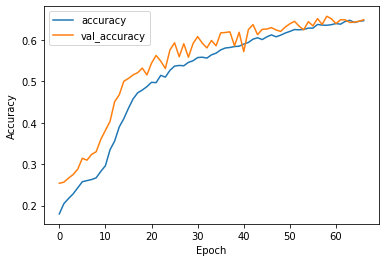

In [62]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()

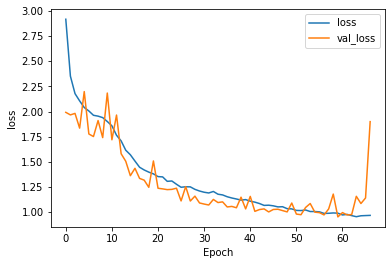

In [63]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend()